#### Date: Jul 2019<br>Programmer:  Patricio López-Serrano, Yiğitcan Özer
This demo illustrates decomposition of a loop-based electronic dance music track, following [1].


#### The notebook proceeds in the following steps:
<br>1. Load audio files for the complete, downmixed track, as well as for the individual loops that the track contains.
<br>2. Compute STFTs for all audio data.
<br>3. Each loop becomes a fixed template ("page") in the tensor W.
<br>The track spectrogram is the target to approximate, V.
<br>We wish to learn the activation matrix H, which answers the question
<br>"Where was each loop activated throughout the track?"
<br>4. Visualize results.


#### References
<br>[1] Patricio López-Serrano, Christian Dittmar, Jonathan Driedger, and
<br>Meinard Müller.
<br>Towards modeling and decomposing loop-based electronic music.
<br>In Proceedings of the International Conference
<br>on Music Information Retrieval (ISMIR), pages 502–508,
<br>New York City, USA, August 2016.


#### If you use the 'NMF toolbox' please refer to:
[2] Patricio López-Serrano, Christian Dittmar, Yiğitcan Özer, and Meinard Müller
<br>NMF Toolbox: Music Processing Applications of Nonnegative Matrix Factorization
<br>In Proceedings of the International Conference on Digital Audio Effects (DAFx), 2019.

#### License:
This file is part of 'NMF toolbox'. 'NMF toolbox' is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. 'NMF toolbox' is distributed in the hope that it will be useful, but ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.

#### You should have received a copy of the GNU General Public License along<br>with 'NMF toolbox'. If not, see http://www.gnu.org/licenses/.

### Initialization

In [1]:
import os
import numpy as np
import scipy.io.wavfile as wav
import IPython.display as ipd
from copy import deepcopy

from NMFtoolbox.forwardSTFT import forwardSTFT
from NMFtoolbox.inverseSTFT import inverseSTFT
from NMFtoolbox.logFreqLogMag import logFreqLogMag
from NMFtoolbox.initActivations import initActivations
from NMFtoolbox.NMFD import NMFD
from NMFtoolbox.visualizeComponentsNMF import visualizeComponentsNMF
from NMFtoolbox.alphaWienerFilter import alphaWienerFilter
from NMFtoolbox.utils import make_monaural, pcmInt16ToFloat32Numpy

inpPath = '../data/'
outPath = 'output/'

filename = 'LSDDM_EM_track.wav'

filenameFX = 'LSDDM_EM_Effects.wav'
filenameBass = 'LSDDM_EM_bass.wav'
filenameMelody = 'LSDDM_EM_melody.wav'
filenameDrums = 'LSDDM_EM_drums.wav'

### 1. Load the audio signal

In [2]:
fs, xTr = wav.read(os.path.join(inpPath, filename))

fsFX, xFX = wav.read(os.path.join(inpPath, filenameFX))
fsBass, xBass = wav.read(os.path.join(inpPath, filenameBass))
fsMelody, xMelody = wav.read(os.path.join(inpPath, filenameMelody))
fsDrums, xDrums = wav.read(os.path.join(inpPath, filenameDrums))

# make monaural if necessary
xTr = make_monaural(xTr)
xFX = make_monaural(xFX)
xBass = make_monaural(xBass)
xMelody = make_monaural(xMelody)
xDrums = make_monaural(xDrums)

# int16 -> float32 conversion
xTr = pcmInt16ToFloat32Numpy(xTr)
xFX = pcmInt16ToFloat32Numpy(xFX)
xBass = pcmInt16ToFloat32Numpy(xBass)
xMelody = pcmInt16ToFloat32Numpy(xMelody)
xDrums = pcmInt16ToFloat32Numpy(xDrums)

### 2. Compute STFT

In [3]:
# spectral parameters
paramSTFT = dict()
paramSTFT['blockSize'] = 4096;
paramSTFT['hopSize'] = 2048;
paramSTFT['winFunc'] = np.hanning(paramSTFT['blockSize'])
paramSTFT['reconstMirror'] = True
paramSTFT['appendFrame'] = True
paramSTFT['numSamples'] = len(xTr)

# STFT computation
XTr, ATr, PTr = forwardSTFT(xTr, paramSTFT);

# get dimensions and time and freq resolutions
numBinsTr, numFramesTr = XTr.shape
deltaT = paramSTFT['hopSize'] / fs
deltaF = fs / paramSTFT['blockSize']

# get logarithmically-spaced frequency axis version for visualization
logFreqLogMagA, logFreqAxis = logFreqLogMag(ATr, deltaF)
numLogBins = len(logFreqAxis)

# repeat for FX loop ---------------------------------------------------
paramSTFT['numSamples'] = len(xFX);

# STFT computation
XFX, AFX, _ = forwardSTFT(xFX, paramSTFT)
XBass, ABass, _ = forwardSTFT(xBass, paramSTFT)
XMelody, AMelody, _ = forwardSTFT(xMelody, paramSTFT)
XDrums, ADrums, _ = forwardSTFT(xDrums, paramSTFT)
numBinsBass, numFramesBass = XBass.shape

### 3. Apply NMF variants to STFT magnitude

In [4]:
# set common parameters
numComp = 4
numIter = 30
numTemplateFrames = deepcopy(numFramesBass)

initW = list()
initW.append(ADrums)
initW.append(AMelody)
initW.append(ABass)
initW.append(AFX)

# generate initial activations
paramActivations = dict()
paramActivations['numComp'] = numComp
paramActivations['numFrames'] = numFramesTr
initH = initActivations(paramActivations, 'uniform')

In [5]:
# NMFD parameters
paramNMFD = dict()
paramNMFD['numComp'] = numComp
paramNMFD['numFrames'] = numFramesTr
paramNMFD['numIter'] = numIter
paramNMFD['numTemplateFrames'] = numTemplateFrames
paramNMFD['initW'] = initW
paramNMFD['initH'] = initH
paramNMFD['numBins'] = numBinsTr
paramNMFD['fixW'] = True

# NMFD core method
nmfdW, nmfdH, nmfdV, _, _ = NMFD(ATr, paramNMFD)

# alpha-Wiener filtering
nmfdA, _ = alphaWienerFilter(ATr, nmfdV, 1)

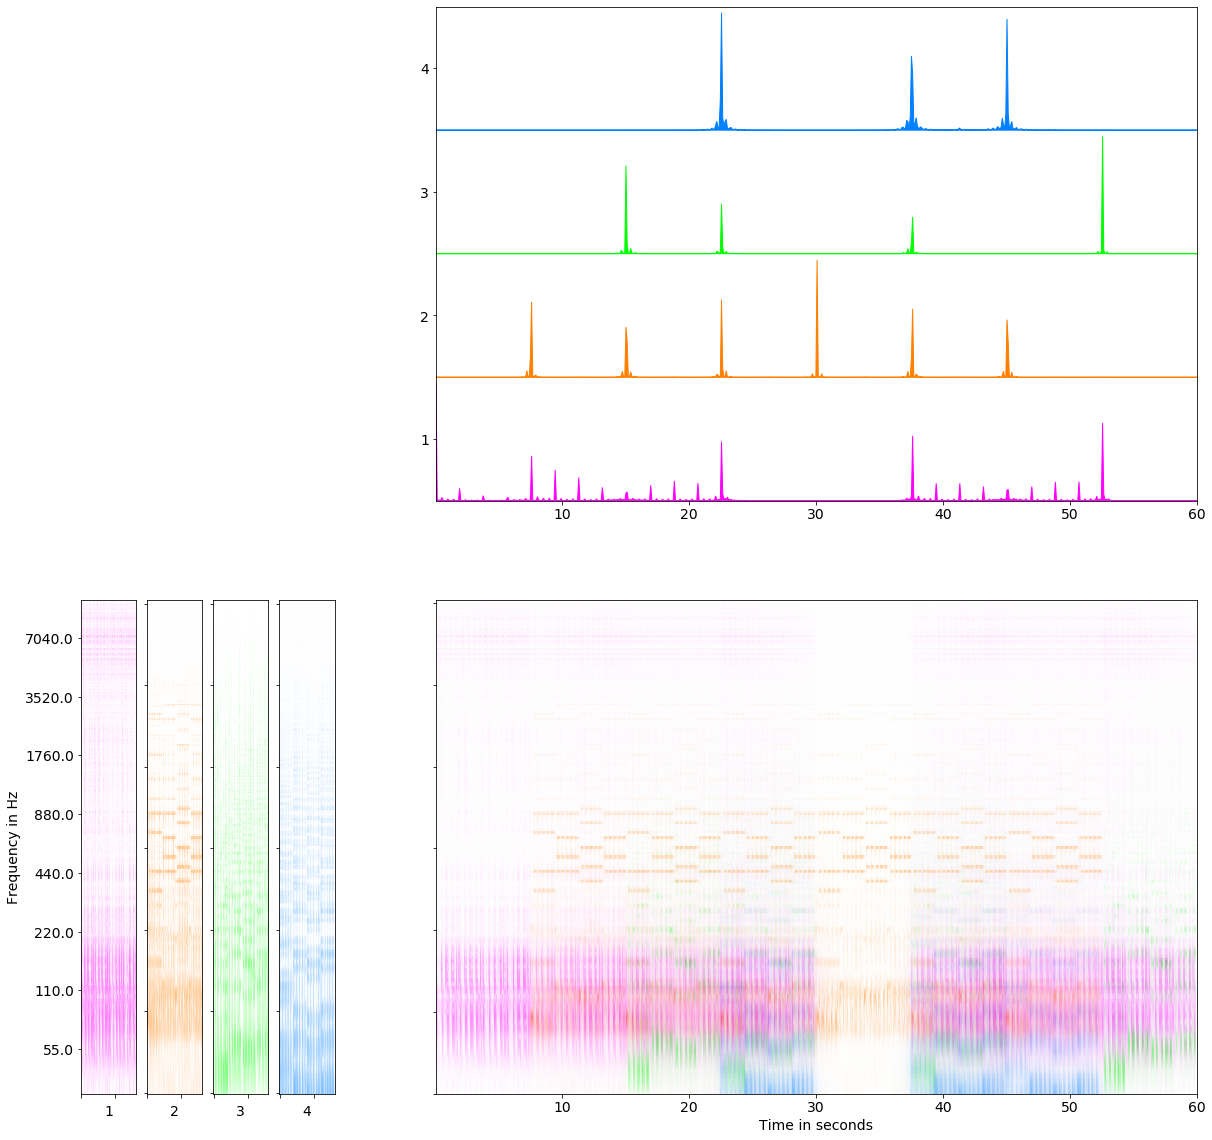

In [6]:
# visualize
paramVis = dict()
paramVis['deltaF'] = deltaF
paramVis['deltaT'] = deltaT
paramVis['fontSize'] = 14
paramVis['logComp'] = 1e5
fh1, _ = visualizeComponentsNMF(ATr, nmfdW, nmfdH, nmfdV, paramVis)
fh1.savefig(os.path.join(outPath, 'LSDDM_EM.png'))